<a href="https://colab.research.google.com/github/emrecicekyurt/TensorFlowTutorialProjects/blob/main/Transfer_Learning_TF_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow : Fine Tuning



In [1]:
# Check if we re using a GPU
!nvidia-smi

Tue Jul  5 08:44:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-05 08:44:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-05 08:44:23 (99.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions to use them later
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


In [4]:
# Lets get some data %10 of training data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2022-07-05 08:44:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   289MB/s    in 0.6s    

2022-07-05 08:44:27 (289 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories we have
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
# Create training and test directory paths
training_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = training_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE,
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent # BatchDataset?

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out labels 
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# an example batch of training data set
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 71.62755     57.62755     54.62755   ]
   [ 82.11735     68.11735     65.11735   ]
   [ 89.938774    75.938774    74.51021   ]
   ...
   [ 62.95388     74.23965     64.81106   ]
   [ 32.443645    52.158       40.229412  ]
   [ 29.117342    55.0459      40.403046  ]]

  [[ 77.02551     63.02551     60.02551   ]
   [ 85.081635    71.081635    68.081635  ]
   [ 91.341835    77.341835    75.91327   ]
   ...
   [ 66.21948     77.50525     68.862366  ]
   [ 83.36751    101.35734     89.42875   ]
   [ 59.275608    82.56132     68.918465  ]]

  [[ 77.5         63.5         60.5       ]
   [ 84.64286     70.64286     69.64286   ]
   [ 89.61735     75.61735     75.40306   ]
   ...
   [ 41.305996    51.35194     43.351933  ]
   [ 33.50517     48.663383    38.949078  ]
   [ 63.770313    82.48969     70.91827   ]]

  ...

  [[ 82.57147     68.57147     41.785736  ]
   [ 85.40312     69.40312     43.60208   ]
   [ 84.933624    68.14791     42.147907  ]
   ...
   [ 59.64279     64.954

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order But our functional API gives us more flexibility with our models

In [11]:
# 1. Create a base model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top= False,)

# 2. Freeze the base model
base_model.trainable = False

#3. Create inputs into models
inputs = tf.keras.layers.Input(shape =(224,224,3), name = "input-layer")

# 4. If using ResNet50V2 u will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#5. Pass the inputs 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output-layer")(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                         experiment_name = "10_percent_feature_extraction",)])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220705-084436
Epoch 1/5
24/24 [==============================] - 22s 240ms/step - loss: 1.8884 - accuracy: 0.4107 - val_loss: 1.3572 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 5s 178ms/step - loss: 1.1499 - accuracy: 0.7293 - val_loss: 0.9623 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - 6s 241ms/step - loss: 0.8395 - accuracy: 0.8147 - val_loss: 0.7681 - val_accuracy: 0.8257
Epoch 4/5
24/24 [==============================] - 5s 204ms/step - loss: 0.6903 - accuracy: 0.8360 - val_loss: 0.6793 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 5s 187ms/step - loss: 0.5926 - accuracy: 0.8547 - val_loss: 0.6570 - val_accuracy: 0.8158


In [12]:
# Evaluate the model
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6028 - accuracy: 0.8464


[0.6028294563293457, 0.8464000225067139]

In [13]:
# Check the layers in our base model

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# summary of base model ? 
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output-layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


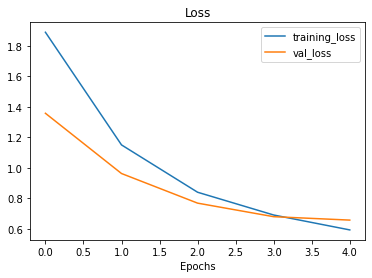

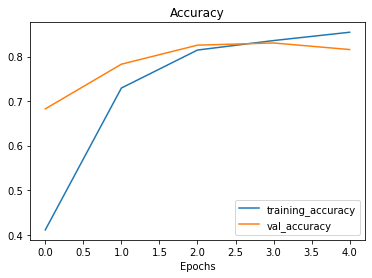

In [16]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Lets demonstrate the Glaobal Average Pooling 2D layer...
 
We have a tensor after our model goes through "base_model" of shape (None, 7, 7, 1280)

But then, when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Lets use a similar shaped tensor (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape = (1,4,4,3)

# Create random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor is : {input_tensor}")

Random input tensor is : [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [18]:
# Pass the random tensor through GlobalAveragePooling2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global Average Pooled Tensor : {global_average_pooled_tensor}")

2D Global Average Pooled Tensor : [[-0.09368646 -0.45840448 -0.2885598 ]]


In [19]:
print(f"Shape of random input tensor is : {input_tensor.shape}")
print(f"Shape of 2D Global Average Pooled Tensor : {global_average_pooled_tensor.shape}")
# Tensor to feature vector 

Shape of random input tensor is : (1, 4, 4, 3)
Shape of 2D Global Average Pooled Tensor : (1, 3)


In [20]:
# Lets replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [21]:
# it is just to see what max pooling does
max_pooled_tensor = tf.keras.layers.MaxPool2D()(input_tensor)
print(f"Max Pooled Tensor : {max_pooled_tensor}")
print(f"Shape of Max Pooled Tensor : {max_pooled_tensor.shape}")

Max Pooled Tensor : [[[[ 0.8504023  -0.40604794  0.3194337 ]
   [ 0.9058464   0.539707    1.6994323 ]]

  [[ 0.77852213  0.4012578   0.97772694]
   [ 0.32410017  1.1603122   0.52744764]]]]
Shape of Max Pooled Tensor : (1, 2, 2, 3)


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of training data, but how does it go with 1% of the training data...
How about we set up a bunch of experiments to find out:

1- "model_1" - use feature extraction transfer learning with 1% of the training data with data augmentation

2- "model_2" - use feature extraction transfer learning with 10% of training data with data augmentation

3- "model_3" - use fine tuning transfer learning on 10% of training data with data augmentation

4- "model_4" - use fine tuning transefer learning on 100% of training data with data augmentation

 Note : Throughout all experiments the same test dataset will be used to evaluate our model. This ensures consistency across evaluation metrics.

## Model_1 Implementation

In [22]:
# Downlaod and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip data from helper.py
unzip_data("10_food_classes_1_percent.zip")

--2022-07-05 08:45:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 172.253.118.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  56.9MB/s    in 2.2s    

2022-07-05 08:45:43 (56.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# create training test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [24]:
# How many images are we working with ? 
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [25]:
# Setup data loaders 

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          label_mode = "categorical",
                                                                          image_size = IMG_SIZE,
                                                                          batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [26]:
# Data augmentation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation with horizontal flipping, rotations, zooms etc.
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      #preprocessing.Rescale(1/255.) # Keep for models like ResNet but EfficientNet doesn need that one
], name = "data-augmentation")

10_food_classes_1_percent/train/chicken_wings/2672056.jpg


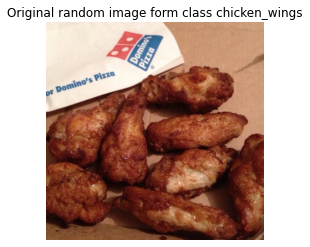

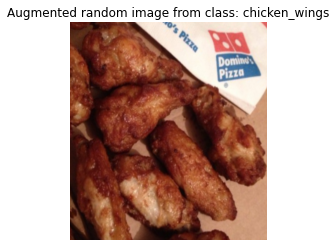

In [27]:
# Lets visualize the data augmentation layer with a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image form class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image 
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0), training= True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img/255.))
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [28]:
# Model_1: Feature extraction transfer learning on 1% of the data with data augmentation

## Setup input shape and base model, freezing the base model layers

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = "input-layer")

# Add in data augmentation Sequiential model as layer
x = data_augmentation(inputs)

# Give base model the inputs dont train it
x = base_model(x, training=False)

# Pool output features of base of the model
x = layers.GlobalAveragePooling2D(name= "global-average-pooling-layer")(x)

# Put a Dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output-layer")(x)

# Make a model 
model_1 = keras.Model(inputs, outputs)

# Compile mode
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs= 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220705-084548
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4426 - accuracy: 0.1000 - val_loss: 2.2542 - val_accuracy: 0.1480
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1249 - accuracy: 0.2571 - val_loss: 2.1407 - val_accuracy: 0.2253
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9949 - accuracy: 0.3571 - val_loss: 2.0390 - val_accuracy: 0.2977
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8105 - accuracy: 0.5286 - val_loss: 1.9452 - val_accuracy: 0.3569
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6756 - accuracy: 0.6000 - val_loss: 1.8664 - val_accuracy: 0.4112


In [29]:
# Checking out the summary of our model
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data-augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global-average-pooling-laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output-layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
# Evaluate on the full dtest data set
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.8358 - accuracy: 0.4388


[1.8358312845230103, 0.43880000710487366]

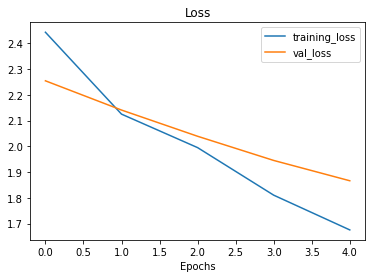

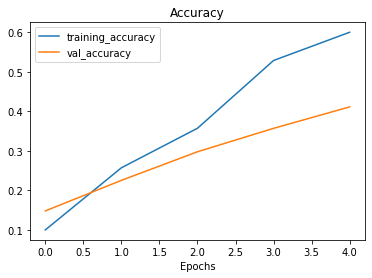

In [31]:
# How about plot loss curves?
plot_loss_curves(history_1_percent)

## Model_2: feature extraction transfer learning model with 10% of data and data augmentation 

In [32]:
# Get the 10% of data .. Since we already did it before no need to run below codes

#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [33]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [34]:
# data loaders again creating for practie
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent =tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode = "categorical",
                                                                           image_size= IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = "categorical",
                                                               image_size= IMG_SIZE,
                                                               batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# build data augmentation sequential layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2),
                                # preprocessing.Rescale(1/255.) if u re using a a model that requires normalization (instead of efficientnet if u r using resnet)
], name = "data-augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

#Create a frozen base model(also called backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input and output including layers between 
inputs = layers.Input(shape= input_shape, name= "input-layer")
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name= "global-average-pooling2D")(x)
outputs = layers.Dense(10, activation="softmax", name= "output-layer")(x)

# create the model
model_2 = tf.keras.Model(inputs, outputs)

#compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_2.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data-augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global-average-pooling2D (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output-layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### ModelCheckPoint callback

It saves our model during the training. It is useful because we can come and start where we left off.

In [36]:
# Set checkpoint path (where it will be saved to)
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a checkmodel callback that saves the models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only= True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",# save every epoch
                                                         verbose = 1)

In [37]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220705-084634
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0169 - accuracy: 0.3133
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 584ms/step - loss: 2.0169 - accuracy: 0.3133 - val_loss: 1.4780 - val_accuracy: 0.6628
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3570 - accuracy: 0.6760
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 428ms/step - loss: 1.3570 - accuracy: 0.6760 - val_loss: 1.0070 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0502 - accuracy: 0.7573
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 349ms/step - loss: 1.0502 - accuracy: 0.7573 - val_loss: 0.8270 - val_accuracy: 0.8010
Ep

In [38]:
# What was the result of model_0
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.6028 - accuracy: 0.8464


[0.6028295159339905, 0.8464000225067139]

In [39]:
# Check model_2 results on test data
result_10_percent_data_aug=model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.6973 - accuracy: 0.8044


[0.6972638964653015, 0.8044000267982483]

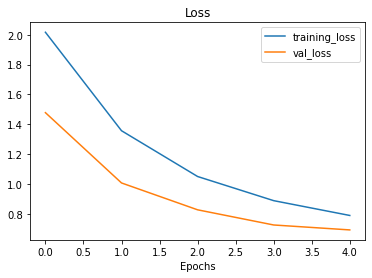

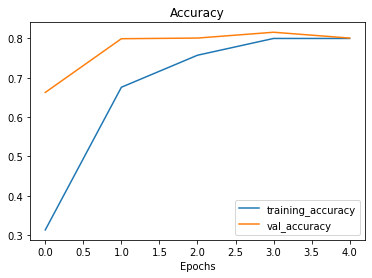

In [40]:
# Plot model_2 loss curves
plot_loss_curves(history_10_percent_data_aug)

In [41]:
# Loading a checkpointed weights that returns a model to a specific checkpoint

# Load in saved model weights and evaluate the model
model_2.load_weights(checkpoint_path)

In [42]:
# Evaluate model_2 with loaded weigths
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6973 - accuracy: 0.8044


In [43]:
# Checking if the loaded weigths of model_2 matches with the weigths which checkpoint callback saved
result_10_percent_data_aug == loaded_weights_model_results

False

In [44]:
result_10_percent_data_aug, loaded_weights_model_results # they are not SAME(only losses) oops!

([0.6972638964653015, 0.8044000267982483],
 [0.697263777256012, 0.8044000267982483])

In [45]:
# Checkin to see whether they are close so much
import numpy as np
np.isclose(np.array(result_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [46]:
# Check the difference between results
print(np.array(result_10_percent_data_aug)- np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


## Model 3 : Fine tuning an existing model on 10% of the data

Note: Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [47]:
# layers in laoded model
model_2.layers

In [48]:
# are these layers trainable ? 

for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd094b2a690> True
<keras.engine.sequential.Sequential object at 0x7fd094ab6e10> True
<keras.engine.functional.Functional object at 0x7fd0945b5790> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd0946dd590> True
<keras.layers.core.dense.Dense object at 0x7fd009f3f7d0> True


In [49]:
# what layers are in our base_model (EfficientB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [50]:
# How many trainable variables (weight or pattern that can be updated) are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [51]:
# To begin fine-tuning lets start by setting the last 10 layers as trainable

base_model.trainable = True

# Un-freeze last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to compile model every time there is a change)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # when fine-tuning you typically want to lower lr by 10x
                 metrics = ["accuracy"] ) 

In [52]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [53]:
# Now we have unfrozen some of the layers on the top 
print(len(model_2.trainable_variables))

12


In [54]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch =  history_10_percent_data_aug.epoch[-1], # Start the epoch where it left before
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                         experiment_name = "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220705-084809
Epoch 5/10
24/24 [==============================] - 17s 408ms/step - loss: 0.7014 - accuracy: 0.7960 - val_loss: 0.5417 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 9s 361ms/step - loss: 0.5777 - accuracy: 0.8373 - val_loss: 0.5027 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 10s 404ms/step - loss: 0.4827 - accuracy: 0.8587 - val_loss: 0.4956 - val_accuracy: 0.8306
Epoch 8/10
24/24 [==============================] - 9s 368ms/step - loss: 0.4451 - accuracy: 0.8533 - val_loss: 0.4635 - val_accuracy: 0.8339
Epoch 9/10
24/24 [==============================] - 10s 404ms/step - loss: 0.3911 - accuracy: 0.8813 - val_loss: 0.4538 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 9s 375ms/step - loss: 0.3688 - accuracy: 0.8867 - val_loss: 0.4703 - val_accuracy: 0.8388


In [55]:
#evaluate the model_3 (model_2 fine tuned)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4937 - accuracy: 0.8340


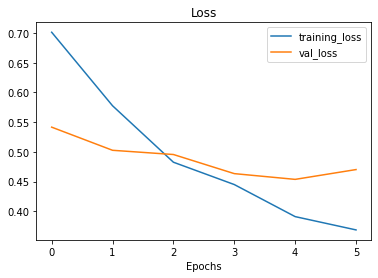

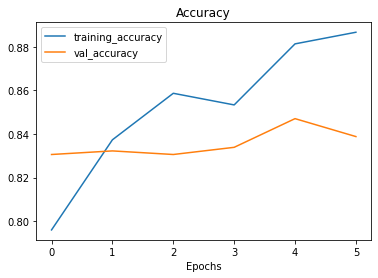

In [56]:
# Check out the loss curves of fine tuned model
plot_loss_curves(history_fine_10_percent_data_aug) # It shows only 5 epochs, while we trained the model for 10 epochs

In [61]:
# Lets create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow history objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new one
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make pllot accuracy
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start fine tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot loss
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start fine tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Loss")

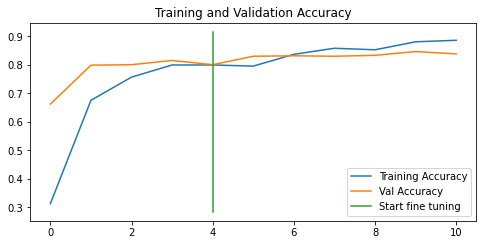

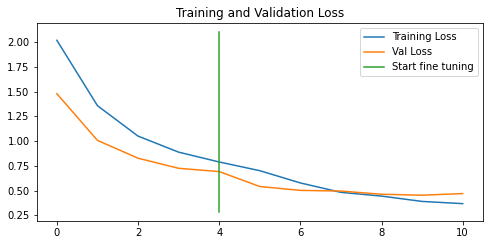

In [62]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug)

## Model 4 : Fine tuning and existing model on all of the data 

In [63]:
# Download and unzip 10 classes of Food 101 data with all images

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-07-05 09:09:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 172.253.118.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   256MB/s    in 1.9s    

2022-07-05 09:09:56 (256 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [64]:
# setup training and test dirs
train_dir_all_data = "10_food_classes_all_data/train"
train_dir = "10_food_classes_all_data/test"

In [65]:
# How many images for both dirs
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [66]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_all_data,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE,
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [67]:
# Evaluate model 2 (fine tuned on 10 percent of data verison)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 100ms/step - loss: 0.4937 - accuracy: 0.8340


[0.4936549663543701, 0.8339999914169312]

In [68]:
results_fine_tune_10_percent

[0.4936549663543701, 0.8339999914169312]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [69]:
# Load weights from checkpoint, to start fine tuning from scratch
model_2.load_weights(checkpoint_path) 

In [70]:
# Lets evaluate model2 now ( should be worser results because its not fine tuned)
model_2.evaluate(test_data)


79/79 [==============================] - 8s 87ms/step - loss: 0.6973 - accuracy: 0.8044


[0.697263777256012, 0.8044000267982483]

In [72]:
# Check to see if model 2 has been reverted back to feature extraction results
result_10_percent_data_aug

[0.6972638964653015, 0.8044000267982483]

In [73]:
# Checkin which layers are tunable
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input-layer True
1 data-augmentation True
2 efficientnetb0 True
3 global-average-pooling2D True
4 output-layer True


In [75]:
# see base models layers
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [76]:
# Recompile (we have to compile model every time there is a change)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # when fine-tuning you typically want to lower lr by 10x
                 metrics = ["accuracy"] ) 

In [77]:
print(len(model_2.trainable_variables))

12


In [78]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch =  history_10_percent_data_aug.epoch[-1], # Start the epoch where it left before
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                         experiment_name = "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220705-093250
Epoch 5/10
235/235 [==============================] - 59s 227ms/step - loss: 0.7312 - accuracy: 0.7656 - val_loss: 0.4469 - val_accuracy: 0.8454
Epoch 6/10
235/235 [==============================] - 48s 204ms/step - loss: 0.5950 - accuracy: 0.8067 - val_loss: 0.3972 - val_accuracy: 0.8701
Epoch 7/10
235/235 [==============================] - 44s 186ms/step - loss: 0.5300 - accuracy: 0.8300 - val_loss: 0.3854 - val_accuracy: 0.8750
Epoch 8/10
235/235 [==============================] - 41s 170ms/step - loss: 0.4960 - accuracy: 0.8380 - val_loss: 0.3611 - val_accuracy: 0.8931
Epoch 9/10
235/235 [==============================] - 40s 168ms/step - loss: 0.4511 - accuracy: 0.8539 - val_loss: 0.3445 - val_accuracy: 0.8947
Epoch 10/10
235/235 [==============================] - 36s 154ms/step - loss: 0.4214 - accuracy: 0.8665 - val_loss: 0.3587 - val_accuracy: 0.8734


In [79]:
# Lets evaluate on all of the test data 
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 8s 83ms/step - loss: 0.3128 - accuracy: 0.8936


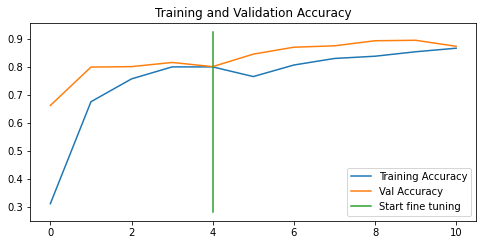

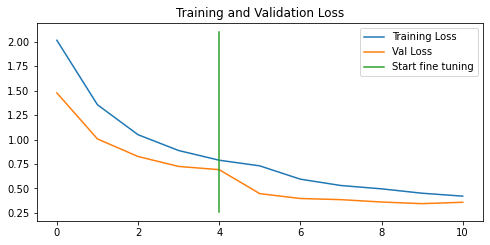

In [80]:
# plot loss acc curves
compare_histories(original_history = history_10_percent_data_aug,
                  new_history= history_fine_10_classes_full)

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should 4 models)
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning Experiments with Food101 Clasees" \
--description "A series of different transfer learning experiments with varyng out amounts of data and fine tuning  "\
--one_shot # exits uploader when its uploaded once


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=f4lZU1bJaibv5f7DNa2OhNwJdgiNCF&prompt=consent&access_type=o